In [3]:
%matplotlib inline

import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy as np

BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
delta_z = 1293.
BT_Z_unique = np.arange(58) * delta_z

BRICK_X_MIN = 27762
BRICK_X_MAX = 72240
BRICK_Y_MIN = 3312
BRICK_Y_MAX = 76710
SAFE_M = 5000
dZ = 205

In [4]:
pbg = pd.read_csv('data_csv/background-129294.csv')
pmc = pd.read_csv('data_csv/mcdata_nue_10k_basetracks.csv')
pmc_sv = pd.read_csv('data_csv/mcdata_nue_10k_showers.csv')

# pbg = pbg.rename(columns={'ele_x': 's.eX', 'ele_y': 's.eY', 'ele_z': 's.eZ', 
#                     'ele_sx': 's.eTX', 'ele_sy': 's.eTY', 'chisquare':'s.eCh'})

In [5]:
pmc = pd.merge(pmc, pmc_sv, on='event_id')

In [6]:
def combine_mc_bg(pmc, pbg, events = [0], bg_frac=0.1):
    '''Create mixed DataFrame from selected MC Even_Id's and
       fraction of background'''
    #first of all generate background with random permutation by Z-axis
    pbg_frac = pbg.sample(frac=bg_frac)
    pbg_frac['ele_z'] = np.random.choice(BT_Z_unique, size=len(pbg_frac))

    dmix = pbg_frac[['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]
    dmix = dmix.rename(columns={'ele_x': 'X', 'ele_y':'Y', 'ele_z': 'Z',
                                'ele_sx': 'TX', 'ele_sy': 'TY'})

    dmix['plate_number'] = pbg_frac['ele_z'].apply(lambda x:
                                                  np.where(BT_Z_unique == x)[0][0] + 1)
    dmix['signal'] = False
    dmix['event_id'] = -999
    
    dd = dmix
    #select showers
    pmc = pmc[pmc.event_id.isin(events)]
    def shift_mc_data_with_margin(pmc, pbg, x_safe_margin = 0, y_safe_margin = 0):
        pmc_new = pmc.copy()
        mc_range = (pmc['ele_x'].max() - pmc['ele_x'].min(), pmc['ele_y'].max() - pmc['ele_y'].min())
        def coordinate_mover(x, min_mc_coord, aplitude, margin):
            return ((x - min_mc_coord) / aplitude - 0.5) * 2* (- margin - (left_bound - right_bound) / 2) +\
                    (left_bound + right_bound) / 2

        right_bound = pbg['ele_x'].max()
        left_bound = pbg['ele_x'].min()

        pmc_new.ele_x = coordinate_mover(pmc.ele_x, pmc['ele_x'].min(), mc_range[0], x_safe_margin)
        pmc_new.BT_X = pmc['BT_X'] - (pmc['ele_x'] - pmc_new.ele_x)

        right_bound = pbg['ele_y'].max()
        left_bound = pbg['ele_y'].min()    

        pmc_new.ele_y = coordinate_mover(pmc.ele_y, pmc['ele_y'].min(), mc_range[1], y_safe_margin)
        pmc_new.BT_Y = pmc['BT_Y'] - (pmc['ele_y'] - pmc_new.ele_y)
        return pmc_new

    pmc_shift = shift_mc_data_with_margin(pmc, pbg, 5000, 5000)

    pmc = pmc_shift[['event_id', 'BT_X', 'BT_Y', 'BT_Z', 'BT_SX', 'BT_SY', 'chisquare']]

    pmc = pmc.rename(columns={'BT_X':'X', 'BT_Y':'Y', 'BT_Z':'Z', 
                              'BT_SX':'TX', 'BT_SY':'TY'})
    
    pmc_sv = pmc_shift[['event_id', 'ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy', 'ele_P']]
    pmc_sv = pmc_sv.rename(columns={'ele_x':'X', 'ele_y':'Y', 'ele_z':'Z', 
                                    'ele_sx':'TX', 'ele_sy':'TY'})
    
    pmc_shift = pd.concat([pmc, pmc_sv], ignore_index=True) #pd.merge(pmc, pmc_sv, on='event_id')
    pmc_shift['signal'] = True
    mix_data = pd.concat([dd, pmc_shift], ignore_index=True)
    
    def clean_outbound_data (new_data):
        x_min = min(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'X'])
        x_max = max(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'X'])
        y_min = min(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'Y'])
        y_max = max(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'Y'])
        z_min = min(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'Z'])
        z_max = max(new_data.loc[pd.isnull(new_data.ele_P)].loc[new_data.signal == False, 'Z'])

        good_data = new_data[(new_data['X'] > x_min) & (new_data['X'] < x_max) & new_data.signal == True]
        good_data = good_data[(good_data['Y'] > y_min) & (good_data['Y'] < y_max)]
        good_data = good_data[(good_data['Z'] > z_min) & (good_data['Z'] < z_max)]
        false_data = new_data[new_data.signal != True]
        all_data = pd.concat([good_data, false_data], axis=0, ignore_index=True)

        ## del some cols
        del_col = ['plate_number']
        all_data.drop(del_col, inplace=True, axis=1)
        all_data = all_data.sample(frac=1).reset_index(drop=True)
        all_data.index = np.arange(0, len(all_data))

        all_data.loc[all_data.signal == False, 'signal'] = 0
        all_data.loc[all_data.signal == True, 'signal'] = 1
        all_data.loc[pd.isnull(all_data.signal), 'signal'] = 1
        all_data.signal.unique()
        all_data.columns

        all_data = all_data.astype(np.float32)

        return all_data
    return clean_outbound_data(mix_data)

In [7]:
def plot_bg_and_mc(pbg, pmc, id=0, step=1):

    def rendering_partition(df):
        # mind the order!
        d0 = df[['Z', 'X', 'Y']][::step]
        d0 = d0.rename(columns={'Z':'z', 'X':'x', 'Y':'y'})
        numtracks = d0.shape[0]

        dd = df[['TX', 'TY']][::step] * dZ
        dd = dd.rename(columns={'TX': 'x', 'TY': 'y'})
        dd.insert(loc=0, column='z', value=dZ)
        d1 = d0 + dd
        return d1, d0
    
    
    d1, d0 = rendering_partition(pbg)
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    d1, d0 = rendering_partition(pmc)
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-15, elev=0)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

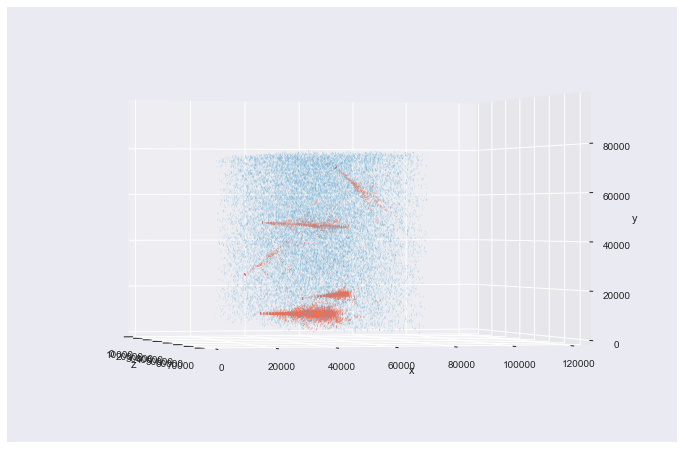

In [8]:
all_indixes = np.unique(pmc.event_id.values)

ind_open = np.random.choice(all_indixes, len(all_indixes)//2, replace=False)
ind_close = list(set(all_indixes) - set(ind_open))
len(ind_open), len(all_indixes), len(ind_close)

showers_count, bg_frequency, bricks_count = 5, 0.001, 1

train, test = pd.DataFrame(), pd.DataFrame()
for brick_num in range(bricks_count):
    new_brick = combine_mc_bg(pmc, pbg, np.random.choice(ind_open, showers_count), bg_frac = bg_frequency)
    new_brick['brick'] = brick_num
    train = pd.concat([train, new_brick], ignore_index=True)

for brick_num in range(bricks_count):
    new_brick = combine_mc_bg(pmc, pbg, np.random.choice(ind_close, showers_count), bg_frac = bg_frequency)
    new_brick['brick'] = brick_num
    test = pd.concat([test, new_brick], ignore_index=True)


# test = combine_mc_bg(pmc, pbg, np.random.choice(ind_close, N), bg_frac = bg_frequency)
plot_bg_and_mc(test.loc[test.signal == False],test.loc[test.signal == True])

In [ ]:
X_train, y_train = train[['TX', 'TY', 'X', 'Y', 'Z', 'chisquare', 'ele_P', 'event_id', 'brick']], train[['signal']]
X_train.to_csv('../data/X_train.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)

X_test, y_test = test[['TX', 'TY', 'X', 'Y', 'Z', 'brick']], test[['signal']]
X_test.to_csv('../data/X_test.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)